# TODO
 - Check the mainstream order of original weight

In [1]:
%matplotlib inline

import numpy as np
from scipy import misc
import matplotlib.pyplot as plt
from scipy import ndimage
import cmath
import math
import Image
from keras.datasets import mnist
from collections import Counter


def resize(input_im):
    im = Image.fromarray(input_im)
    im = im.resize([10,10], Image.ANTIALIAS)
    rz_im = np.asarray((im.getdata()))
    return np.reshape(rz_im, (10,10))

def getXsvd(imgmat,k):
    U, sigma, V = np.linalg.svd(imgmat)
    reconstimg = np.matrix(U[:, :k]) * np.diag(sigma[:k]) * np.matrix(V[:k, :])
#     plt.imshow(reconstimg, cmap='gray')
    return reconstimg
    
def getX_10():    
    X_10_train = np.zeros((60000,10,10))
    X_10_test =  np.zeros((10000,10,10))
    (X_train, _), (X_test, _) = mnist.load_data()
    for i in range(X_train.shape[0]):
        X_10_train[i,:,:] = resize(X_train[i])
    for i in range(X_test.shape[0]):
        X_10_test[i,:,:] = resize(X_test[i])
    return X_10_train,X_10_test

def get_mode_by_order(w):
    data = Counter(w.flatten())
    mode_w = data.most_common(len(data))  # Returns the highest occurring item
    
    dic = {}

    for num in mode_w:
        for j in [10, 100, 1000, 10000, 100000, 1000000, 10000000, 100000000, 1000000000, 10000000000, 100000000000, 1000000000000, 10000000000000, 100000000000000, 1000000000000000, 10000000000000000, 100000000000000000, 1000000000000000000, 10000000000000000000L, 100000000000000000000L, 1000000000000000000000L, 10000000000000000000000L, 100000000000000000000000L, 1000000000000000000000000L, 10000000000000000000000000L, 100000000000000000000000000L, 1000000000000000000000000000L, 10000000000000000000000000000L, 100000000000000000000000000000L]:
            res = abs(num[0] * j)
            if res >= 1 and res < 10:
                dic[j] = dic.get(j,0)+1
    
    return dic.iteritems()        

def get_lw(l_wrt_w):
    loss = np.zeros((512,10))
    weights = np.zeros((512,10))

    for i in range(512):
        for j in range(10):
            loss[i,j] = l_wrt_w[i,j,0]
            weights[i,j] = l_wrt_w[i,j,1]    
    return loss,weights

Using Theano backend.


# Playing with last layer (only Dense10)

In [2]:
from __future__ import print_function
import numpy as np
import random
np.random.seed(1337)  # for reproducibility

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils
from keras.regularizers import l2, activity_l2


batch_size = 512
nb_classes = 10
nb_epoch = 256

train_slice = 1000
test_slice = 10000


# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_test /= 255

X_train_10000 = X_train[:train_slice]
X_test_10000 = X_test[:test_slice]

print(X_train_10000.shape[0], 'train samples')
print(X_test_10000.shape[0], 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train[:train_slice], nb_classes)
Y_test = np_utils.to_categorical(y_test[:test_slice], nb_classes)

FC0 = Dense(512, input_shape=(784,))
FC1 = Dense(512)
FC2 = Dense(10)

model = Sequential()
model.add(FC0)
model.add(Activation('relu'))
model.add(FC1)
model.add(Activation('relu'))
model.add(FC2)
model.add(Activation('softmax'))

model.summary()

model.compile(loss='mse',
              optimizer='adadelta',
              metrics=['accuracy'])

history = model.fit(X_train_10000, Y_train,
                    batch_size=batch_size, nb_epoch=nb_epoch,
                    verbose=0, validation_data=(X_test_10000, Y_test))
score = model.evaluate(X_test_10000, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])
test_score = score[0]

score = model.evaluate(X_train_10000, Y_train, verbose=0)
print('Train score:', score[0])
print('Train accuracy:', score[1])

1000 train samples
10000 test samples
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_1 (Dense)                  (None, 512)           401920      dense_input_1[0][0]              
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 512)           0           dense_1[0][0]                    
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 512)           262656      activation_1[0][0]               
____________________________________________________________________________________________________
activation_2 (Activation)        (None, 512)           0           dense_2[0][0]                    
_____________________________________________________

In [4]:
layer4_weights = np.copy(model.layers[4].get_weights())

l4_alt_10 = np.copy(layer4_weights)
l_wrt_w_10 = np.zeros(layer4_weights[0].shape + (2,))

l4_alt_100 = np.copy(layer4_weights)
l_wrt_w_100 = np.zeros(layer4_weights[0].shape + (2,))

l4_alt_200 = np.copy(layer4_weights)
l_wrt_w_200 = np.zeros(layer4_weights[0].shape + (2,))

model.layers[0].set_weights(model.layers[0].get_weights())
model.layers[2].set_weights(model.layers[2].get_weights())

# Change the weight only 1 at the time
# evaluate the loss thru the network
# - calculate diff of 
#   - 1) Test Score 
#   - 2) Weight difference (From the original and the altered one[/10 and /100])
# set the weight back 

for idx in [0,2,4]:
    model.layers[idx].trainable = False

for i in range(l_wrt_w_10.shape[0]):
    for j in range(l_wrt_w_10.shape[1]):
        '''
         save the weight dummy
         alter the value of the weight by 10,100,200
         set the weight back to the network and compute the loss
         save the score differences and the weight differences into the l_wrt_w matrix
         set the weight that we altered back with the dummy
         
         IMP: Need to do for each weight because Python has something weird in its
         Matrix references, considered read more Python book, but this works anyway
        '''
        w_dummy = layer4_weights[0][i][j]
        l4_alt_10[0][i][j] /= 10
        model.layers[4].set_weights(l4_alt_10)
        score_10 = model.evaluate(X_test_10000, Y_test, verbose=0)
        l_wrt_w_10[i][j][0] = test_score - score_10[0]
        l_wrt_w_10[i][j][1] = w_dummy - l4_alt_10[0][i][j]
        l4_alt_10[0][i][j] = w_dummy
        
        w_dummy = layer4_weights[0][i][j]
        l4_alt_100[0][i][j] /= 100
        model.layers[4].set_weights(l4_alt_100)
        score_100 = model.evaluate(X_test_10000, Y_test, verbose=0)
        l_wrt_w_100[i][j][0] = test_score - score_100[0]
        l_wrt_w_100[i][j][1] = w_dummy - l4_alt_100[0][i][j]
        l4_alt_100[0][i][j] = w_dummy

        w_dummy = layer4_weights[0][i][j]
        l4_alt_200[0][i][j] /= 200
        model.layers[4].set_weights(l4_alt_200)
        score_200 = model.evaluate(X_test_10000, Y_test, verbose=0)
        l_wrt_w_200[i][j][0] = test_score - score_200[0]
        l_wrt_w_200[i][j][1] = w_dummy - l4_alt_200[0][i][j]        
        l4_alt_200[0][i][j] = w_dummy
        
        if (j%5 == 0 and i%5 == 0):
            print("i,j,l_wrt_w_10,l_wrt_w_100,l_wrt_w_200 = ", i, j,
                 l_wrt_w_10[i][j][1],
                 l_wrt_w_100[i][j][1],
                 l_wrt_w_200[i][j][1])

i,j,l_wrt_w_10,l_wrt_w_100,l_wrt_w_200 =  0 0 0.113191463053 0.124510608613 0.125139445066
i,j,l_wrt_w_10,l_wrt_w_100,l_wrt_w_200 =  0 5 -0.0562763921916 -0.0619040317833 -0.0622166804969
i,j,l_wrt_w_10,l_wrt_w_100,l_wrt_w_200 =  5 0 -0.0294050909579 -0.0323456004262 -0.0325089618564
i,j,l_wrt_w_10,l_wrt_w_100,l_wrt_w_200 =  5 5 0.018474182114 0.0203216001391 0.0204242356122
i,j,l_wrt_w_10,l_wrt_w_100,l_wrt_w_200 =  10 0 -0.0247845239937 -0.0272629782557 -0.0274006687105
i,j,l_wrt_w_10,l_wrt_w_100,l_wrt_w_200 =  10 5 0.0149773946032 0.0164751335979 0.016558341682
i,j,l_wrt_w_10,l_wrt_w_100,l_wrt_w_200 =  15 0 0.0329471342266 0.0362418480217 0.0364248901606
i,j,l_wrt_w_10,l_wrt_w_100,l_wrt_w_200 =  15 5 -0.0793589353561 -0.0872948244214 -0.0877357125282
i,j,l_wrt_w_10,l_wrt_w_100,l_wrt_w_200 =  20 0 0.039031483233 0.0429346300662 0.0431514717638
i,j,l_wrt_w_10,l_wrt_w_100,l_wrt_w_200 =  20 5 0.0865985751152 0.0952584370971 0.0957395359874
i,j,l_wrt_w_10,l_wrt_w_100,l_wrt_w_200 =  25 0 -

# Save the l_wrt_w in file

In [5]:
# import pickle

# with open('l_wrt_w_10_newscript', 'wb') as handle:
#     pickle.dump(l_wrt_w_10, handle)
    
# with open('l_wrt_w_100_newscript', 'wb') as handle:
#     pickle.dump(l_wrt_w_100, handle)
    
# with open('l_wrt_w_200_newscript', 'wb') as handle:
#     pickle.dump(l_wrt_w_200, handle)

# pf = open('l_wrt_w_lastlayer_9888','rb')
# l_wrt_w = pickle.load(pf)

In [29]:
l_diff_10, w_diff_10 = get_lw(l_wrt_w_10)
l_diff_100, w_diff_100 = get_lw(l_wrt_w_100)
l_diff_200, w_diff_200 = get_lw(l_wrt_w_200)
# sorted_by_second = sorted(data, key=lambda tup: tup[1])

print (sorted([(1./k,v) for (k,v) in get_mode_by_order(l_diff_10/w_diff_10)],key=lambda tup:tup[1],reverse=True))
print (sorted([(1./k,v) for (k,v) in get_mode_by_order(l_diff_100/w_diff_100)],key=lambda tup:tup[1],reverse=True))
print (sorted([(1./k,v) for (k,v) in get_mode_by_order(l_diff_200/w_diff_200)],key=lambda tup:tup[1],reverse=True))

[(0.0001, 2346), (1e-05, 1557), (1e-06, 590), (1e-07, 328), (1e-08, 121), (1e-09, 52), (0.001, 44), (1e-10, 29), (1e-11, 6)]
[(0.0001, 2341), (1e-05, 1557), (1e-06, 596), (1e-07, 327), (1e-08, 118), (1e-09, 51), (0.001, 45), (1e-10, 33), (1e-11, 5)]
[(0.0001, 2341), (1e-05, 1557), (1e-06, 598), (1e-07, 325), (1e-08, 118), (1e-09, 53), (0.001, 45), (1e-10, 31), (1e-11, 5)]


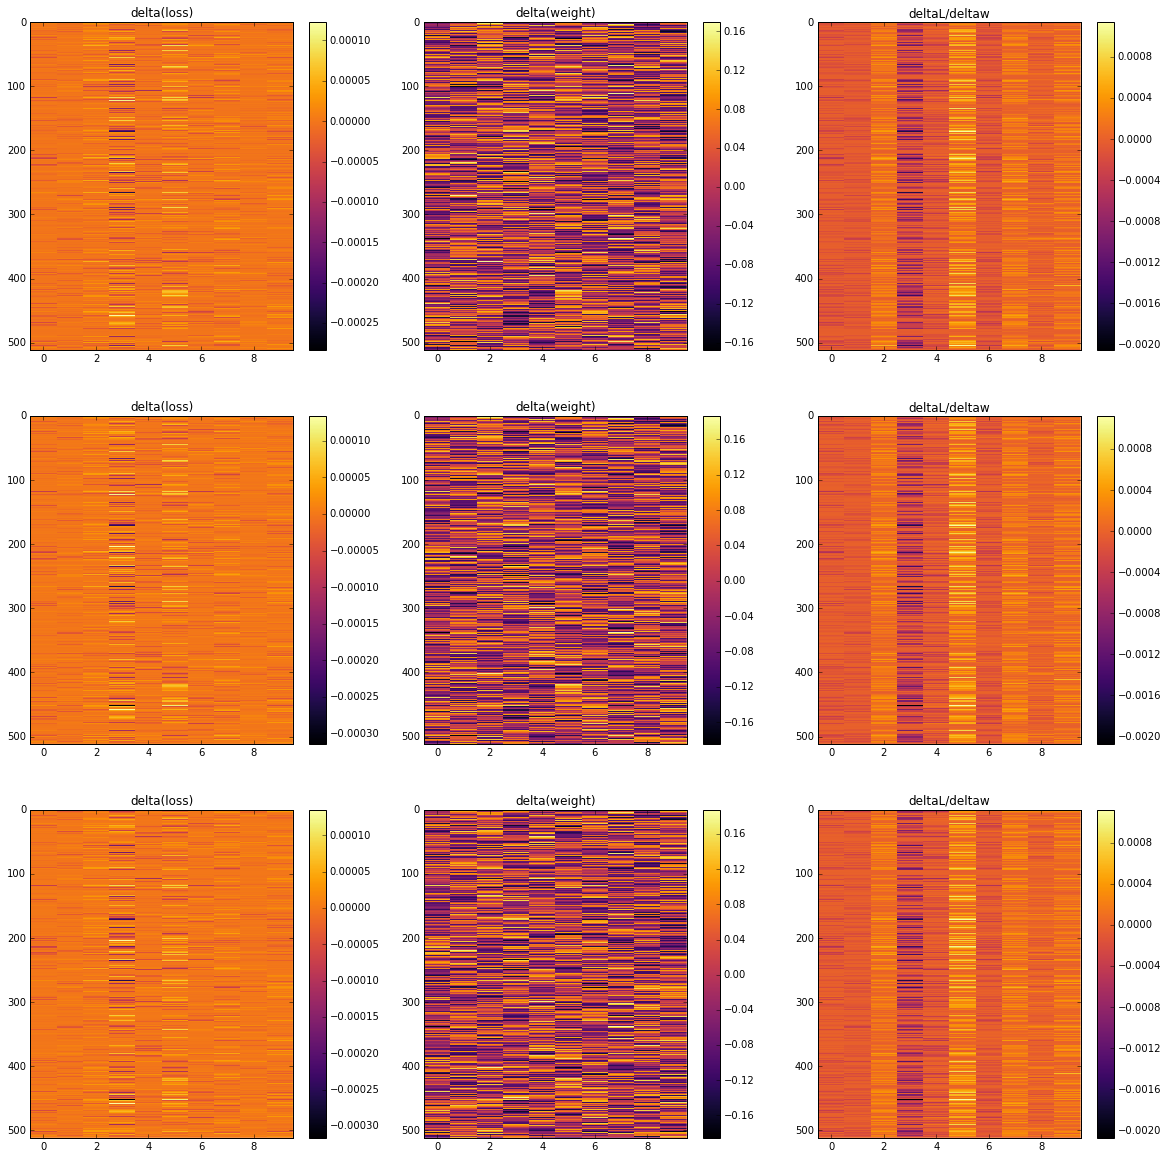

In [31]:
plt.figure(figsize=(20,20))
plt.subplot(331)
plt.imshow(l_diff_10, cmap='inferno', aspect='auto', interpolation='none')
plt.title('delta(loss)')
plt.colorbar()

plt.subplot(332)
plt.imshow(w_diff_10, cmap='inferno', aspect='auto', interpolation='none')
plt.title('delta(weight)')
plt.colorbar()

plt.subplot(333)
plt.imshow(l_diff_10/w_diff_10, cmap='inferno', aspect='auto', interpolation='none')
plt.title('deltaL/deltaw')
plt.colorbar()

plt.subplot(334)
plt.imshow(l_diff_100, cmap='inferno', aspect='auto', interpolation='none')
plt.title('delta(loss)')
plt.colorbar()

plt.subplot(335)
plt.imshow(w_diff_100, cmap='inferno', aspect='auto', interpolation='none')
plt.title('delta(weight)')
plt.colorbar()

plt.subplot(336)
plt.imshow(l_diff_100/w_diff_100, cmap='inferno', aspect='auto', interpolation='none')
plt.title('deltaL/deltaw')
plt.colorbar()

plt.subplot(337)
plt.imshow(l_diff_200, cmap='inferno', aspect='auto', interpolation='none')
plt.title('delta(loss)')
plt.colorbar()

plt.subplot(338)
plt.imshow(w_diff_200, cmap='inferno', aspect='auto', interpolation='none')
plt.title('delta(weight)')
plt.colorbar()

plt.subplot(339)
plt.imshow(l_diff_200/w_diff_200, cmap='inferno', aspect='auto', interpolation='none')
plt.title('deltaL/deltaw')
plt.colorbar()

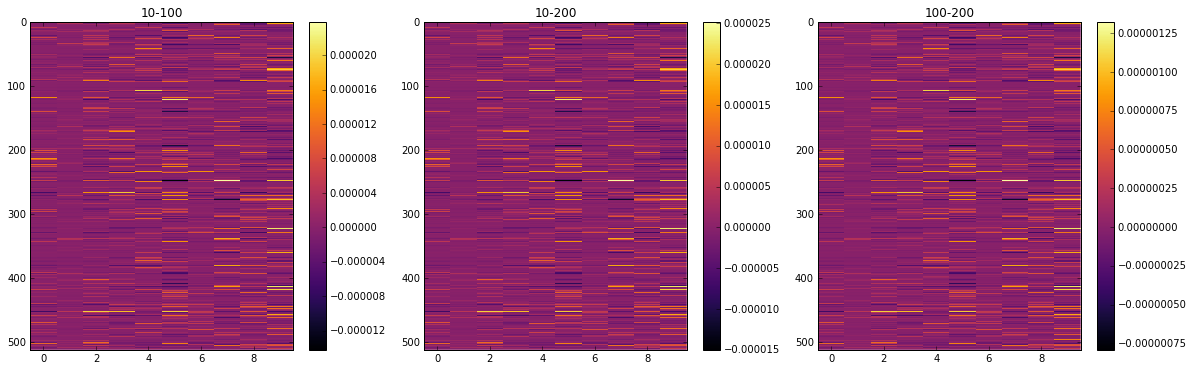

In [8]:
plt.figure(figsize=(20,20))
plt.subplot(331)
plt.imshow((l_diff_10/w_diff_10) - (l_diff_100/w_diff_100), cmap='inferno', aspect='auto', interpolation='none')
plt.title('10-100')
plt.colorbar()

plt.subplot(332)
plt.imshow((l_diff_10/w_diff_10) - (l_diff_200/w_diff_200), cmap='inferno', aspect='auto', interpolation='none')
plt.title('10-200')
plt.colorbar()

plt.subplot(333)
plt.imshow((l_diff_100/w_diff_100) - (l_diff_200/w_diff_200), cmap='inferno', aspect='auto', interpolation='none')
plt.title('100-200')
plt.colorbar()

# How much the weight is incremented for each epoch?
 - run another epoch, get the mode of weight difference
 - got the most popular at 1e-05

In [111]:
print(dic)
for k,v in dic.iteritems():
    print(1.0/k, v)

{1000000000: 14, 100000000: 51, 10000: 177, 1000000: 975, 10000000: 224, 100000: 3133}
1e-09 14
1e-08 51
0.0001 177
1e-06 975
1e-07 224
1e-05 3133


# Finding the nb of order that most used to represent keras's weight